In [67]:
#Importações
import numpy as np
import numpy.random as npr
import random as rd
from sklearn import datasets
import pandas as pd
import copy
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (15,8)
import seaborn as sns; sns.set(color_codes=True)
import csv
import math
import json
from operator import itemgetter

In [68]:
#> Individuo: representa um conjunto de recursos alocados em um espaço 
#Ex.: Planilha de horario de alocação das disciplinas. 
#
#> Gene: É composto por uma cadeia de Cromossomos, que ao todo vai representar uma 
# escala de horarios para os professores em turmas diferentes, porém no mesmo curso.
#
#> Cromossomos: Cada Cromossomo representa uma Turma, e cada turma tem tuplas, com informações da
# tabela de horarios dos professores.
#==> Tupla: Turmas( Dias[ Periodos {Professores} ] )
#
# **************
# *** Regras *** 
# **************
# === RIGIDAS ===
# 1. Limite finito de aulas que cada professor pode dar para cada turma.
# 2. Um professor não pode dar aula ao mesmo tempo no mesmo horario em turmas diferentes.
#
# === Leves ===
#
# **************
#
#maxChromosome: representa o maximo de escalas possiveis para os recursos
#sliceChromosome: Divide escalas (Ex.: Max=10 e slice=5, pode ser 10 horas de aula em 5 dias (2 aulas por dia) )
#repetitionRes: Quantas vezes o recurso especifico deve existir na escala (Ex.: Tem professor com 2 ou 3 aulas)

class Individuo():  

    # === Dados ===
    #T = Turmas | limitT = Limite de aulas na turma especifica
    #P = Professores | Pe = Periodos (Horarios) 
    #D = Dias da semana (Ex.: Segunda a sexta)
    #data        = None
    gene        = []             #Cadeia de Cromossomos [Turma, Dia/Semana, Hora/Periodo]
    schoolClass = [0, 1, 2, 3]                 #Turmas
    days        = [0, 1, 2, 3, 4]        #Segunda(0) a Sexta(4)
    timetable   = [0, 1, 2, 3]           #horário [ 0(1º - 8 as 10), 1(10:15 as 12), 2(14 as 16), 3(16:15 as 18)]
    teachers    = [0, 1, 2]        #Professores
    teachersQt    = [2, 2, 2]      #Professores e maximo de aulas por turma na semana

    fitness         = 0.00         #Pontuação do Individuo
    chanceMutation  = 0.04        #Chance de ocorrer a mutação (Ex.: 0.04 é 4%)

    slots = []

    #Inicializa os atributos do Individuo
    def __init__(self):
        #self.data =  json.load(open("dados.json"))
        self.createGenes()
        self.fitnessFunc()

    def createGenes(self):
        self.slots = []
        self.gene = []
        daysTemp = copy.deepcopy(self.days)
        timetableTemp = copy.deepcopy(self.timetable)
        #Adiciona as turmas (Cromossomos) ao gene
        for i_sc in range(len(self.schoolClass)):
            self.gene.append([])      
            for i_tc in range(len(self.teachers)):
                #Cria copias das matrizes do dia da semana e periodos/horarios e mistura.
                rd.shuffle(daysTemp)
                countTT = 0
                for q in range(self.teachersQt[i_tc]):
                    rd.shuffle(timetableTemp)
                    self.gene[i_sc].append([daysTemp[countTT], timetableTemp[0], self.teachers[i_tc]]) 
                    self.slots.append([daysTemp[countTT], timetableTemp[0], self.teachers[i_tc]])
                    countTT +=1
        #print(len(self.gene))
#        for x in self.gene:
#            print(x)

    #Calcula o Fitness
    def fitnessFunc(self):
        self.fitness += self.objective1()
    
    #Calcula o valor do 1º Objetivo (Mono Objetivo)
    def objective1(self):
        rigidRules = 0.01
        listTemp = self.count_duplicates(self.slots)
        for i in range(len(listTemp)):
                if listTemp[i][1] > 1:
                    rigidRules +=1
        #print(listTemp)        
        #print(rigidRules)
        return rigidRules

    def count_duplicates(self,input_list):
            count_list = []
            for each in input_list:
                new_count = [each, input_list.count(each)]
                if count_list.count(new_count) >= 1:
                    continue
                else:
                    count_list.append(new_count)
            return count_list

    #Aplica a Mutação
    def applyMutation(self):
        if self.probably(self.chanceMutation):
            return 0

    #Desnormaliza para uma faixa de valores [x = min + (max-min) * value]
#    def denormalization(self, matriz, minGeneValue, maxGeneValue):
#        for i in range(0, len(matriz)-1):
#            matriz[i] = minGeneValue + (maxGeneValue-minGeneValue) * matriz[i]

    #Normaliza para uma faixa de valores [normalized = ( x - Xmin ) / ( Xmax - Xmin )]
 #   def normalization(self, matriz):
 #       return (matriz - np.min(matriz)) / (np.max(matriz) - np.min(matriz))

    #Calcula a chance de algo ocorrer (Ex.: 0.14 é 14% de ocorrer algo)
    def probably(self, chance):
        return npr.random() <= chance

   #Cruzamento (50% dos genes do pai e 50% dos genes da mãe)
    #cross...(pai, mae) e cross...(mae, pai) = gera 2 filhos com as metades dos pais.
    def crossoverGenesAndTestMutation(self, parentChromosome1, parentChromosome2, probabilityMutation):
        self.gene = []        
        sizeChromosome = len(parentChromosome1.gene)
        halfChromosome = math.floor(sizeChromosome/2)
        for i in range(0, halfChromosome):
            self.gene.append(parentChromosome1.gene[i])
        for i in range(halfChromosome, sizeChromosome):
            self.gene.append(parentChromosome2.gene[i])
        self.testMutationGenes(probabilityMutation)

    #Após a criação dos Genes e a estruturação dos cromossomos, aplica a chance de mutação nos mesmos
    def testMutationGenes(self, probabilityMutation):
        for pos in range(len(self.gene)):
            #Verifica se vai ocorrer mutação Para cada Cromossomo no Gene
            if self.probably(probabilityMutation):
                slotsTmp = self.gene[pos]
                value1 = self.gene[pos][0][2]
                value2 = self.gene[pos][len(slotsTmp)-1][2]
                self.gene[pos][0][2] = value2
                self.gene[pos][len(slotsTmp)-1][2] = value1
                #print(value1)
                #print(value2)
                #print(self.gene[pos][0][2])
                #print(self.gene[pos][len(slotsTmp)-1][2])
                #print("------xxx------")

    #Competição entre dois individuos, vence o melhor fitness
    def selection(self, rival):
        #Quanto mais perto de zero melhor
        if self.fitness <= rival.fitness:
            return copy.deepcopy(self)
        else:
            return copy.deepcopy(rival)

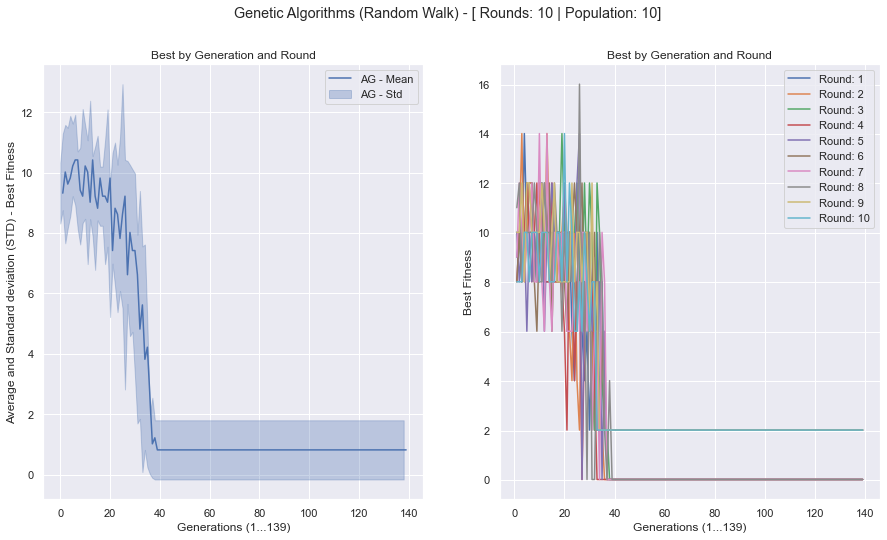

c:\Users\miche\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [69]:
#Populacao
#* Seleção: roleta, torneio, classificação/ranking, truncamento
#* Reprodução: acasalamento, recombinação e mutação
#-----
#Nota: A população deve sempre ser um valor par, esta foi a regra que condicionei para facilitar a situação (Pop/2) fechar em par.
class Populacao():
    
    #---------
    population              =   []      #Conjunto de Individuos de uma geração
    sizePopulation          =   100     #Total de individuos na população
    bestIndGeneration       =   []      #Melhor individuo de cada Geração
    bestIndividuo           =   None    #Guarda o ULTIMO melhor individuo da geração
    countNoEvolution        =   0       #Contador de fitness que não evolui (count_stagnation)
    limitNoEvolution        =   100     #Limite maximo de fitness que não evolui (Limite K)
    evolution               =   0.01    #Se por K gerações a qualidade da solução ficou abaixo de um delta (= 0.01, por exemplo), então o algoritmo alcançou sua condição de parada.
    intervalCrossover       =   [0.9, 0.6]              #Chance de cruzamento inicia em 90% e termina em 60% (Cai de 1%), durante as gerações e não por cromossomo
    probabilityCrossover    =   intervalCrossover[0]    #Chance real dos pais cruzarem, caso contrario seus genes vão  na integra para a proxima geração
    intervalMutation        =   [0.4, 0.01]             #Chance de Mutação inicia em 60% e termina em 4% (Cai de 1%), durante as gerações e não por cromossomo
    probabilityMutation     =   intervalMutation[0]     #Chance real de ocorrer a mutação
    sigmaMutation           =   0.10                    #Desvio Padrão da Mutação
    #---------
    listGenerations         =   []      #Matriz de "bestIndGeneration" (Guarda os dados gerais da geração e melhores individuos)
    meanBestFitness         =   []      #Média das Gerações guardadas em "listGenerations"
    stdBestFitness          =   []      #Desvio Padrão das Gerações guardadas em "listGenerations"
    rounds                  =   10      #Maximo de Rodadas (1 Rodada tem N gerações)    
    #----------
    numMaxGenerations       =   []      #só guarda os numeros das gerações 0 a N para o plot no grafico
    #----------
    x1mean = []
    x1std = []
    x2mean = []
    x2std = []
    meanBestFitnessGeral = 0
    stdBestFitnessGeral = 0
    recomendIndividuo = None
    
    #Atualiza a probabilidade Mutação.
    def updateProbMutation(self):
        if (self.probabilityMutation == self.intervalMutation[1]):
            return self.probabilityMutation
        else:
            if self.probably(0.50)==True: #50% chance re reduzir 1% da chance de mutação
                self.probabilityMutation -= 0.01
        return self.probabilityMutation


    #Atualiza a probabilidade Cruzamento.
    def updateProbCrossover(self):
        if (self.probabilityCrossover == self.intervalCrossover[1]):
            return self.probabilityCrossover
        else:
            if self.probably(0.50)==True: #50% chance re reduzir 1% da chance de mutação
                self.probabilityCrossover -= 0.01
        return self.probabilityCrossover

    #Cria a 1ª população (Inicial)
    def createInitialPopulation(self):
        size = self.sizePopulation - len(self.population)
        for i in range(size):
            novoIndividuo = Individuo()
            novoIndividuo.createGenes()
            #Não precisa aplicar mutação na 1ª geração
            novoIndividuo.fitnessFunc()
            self.population.append(novoIndividuo)

    #Calcula a chance de algo ocorrer (Ex.: 0.14 é 14% de ocorrer algo)
    def probably(self, chance):
        return npr.random() <= chance

    def selectionAndReproduction(self):        
        parentsWin  = []            #Individuos vencedores na Seleção/Cruzamento 
        parentsNewGenerations = []  #População final
        
        # == Seleção ==
        for i in range(0, 2):
            #Mistura os individuos
            npr.shuffle(self.population)    
            #Pega e em 2 para competir
            for i in range(0, len(self.population), 2):
                #Torneio: O de melhor fitness vence
                parentsWin.append(self.population[i].selection(self.population[i+1]))

        # == Reprodução == 
        for i in range(0, len(parentsWin), 2):
            # Testa se vai haver Cruzamento de Genes ou repetição
            prob = self.updateProbCrossover()
            if self.probably(prob)==True:
                #Cruzamento: Acasalamento
                novoIndividuoA = Individuo()
                novoIndividuoB = Individuo()

                #Cruzamento: Recombinação e mutação
                novoIndividuoA.crossoverGenesAndTestMutation(parentsWin[i], parentsWin[i+1], self.updateProbMutation())
                novoIndividuoA.fitnessFunc()
                
                novoIndividuoB.crossoverGenesAndTestMutation(parentsWin[i+1], parentsWin[i], self.updateProbMutation())
                novoIndividuoB.fitnessFunc()
                
                #Salva os novos individuos
                parentsNewGenerations.append(novoIndividuoA)
                parentsNewGenerations.append(novoIndividuoB)
            
            #Os Genes dos pais passam para geração seguinte na integra
            else:        
                #Salva os novos individuos                                                   
                parentsNewGenerations.append(copy.deepcopy(parentsWin[i]))
                parentsNewGenerations.append(copy.deepcopy(parentsWin[i+1]))
        
        #Atualiza a nova população
        self.population = parentsNewGenerations

    def runPopulation(self, maxRounds, sizePop):
        self.sizePopulation         = sizePop
        self.rounds                 = maxRounds
        self.listGenerations        =  []
        self.meanBestFitness        =  []
        self.stdBestFitness         =  []
        self.numMaxGenerations      =  []

        #N Rodadas.
        for i in range(0, self.rounds): 
            self.population             =   []
            self.bestIndGeneration      =   []
            self.bestIndividuo          =   None
            self.countNoEvolution       =   0
            self.probabilityMutation    =   self.intervalMutation[0]
            self.probabilityCrossover   =   self.intervalCrossover[0]

            #N Gerações até que o maximo de gerações sem mudança seja atingido.
            while(True):

                if (self.bestIndividuo == None):
                   #Cria a população Inicial
                   self.createInitialPopulation()
                else:
                    #Atualiza a população [Aplica Seleção e Reprodução (Cruzamento e Mutação)]
                    self.selectionAndReproduction()

                #-------------------
                #Ordena a população
                self.orderPopByFitness()
                #Guarda o melhor Individuo desta Geração/Rodada
                currentBestIndividuo = self.population[0]
                
                #Gerencia aquantidade de gerações sem mudanças.
                if (self.bestIndividuo != None):
                    var_fitness = abs(currentBestIndividuo.fitness-self.bestIndividuo.fitness)/self.bestIndividuo.fitness
                    if var_fitness < self.evolution:
                        self.countNoEvolution += 1
                    else:
                        self.countNoEvolution = 0

                #Pega o melhor individuo e Guarda pra geração seguinte
                self.bestIndividuo = currentBestIndividuo

                #Guarda o melhor individuo desta geração/Rodada
                if (self.bestIndividuo != None): 
                    self.bestIndGeneration.append(self.bestIndividuo)

                #Verifica se chegamos na ultima geração
                if self.countNoEvolution == self.limitNoEvolution:
                    break

            #Guarda esta geração de melhores individuos na lista.
            self.listGenerations.append(self.bestIndGeneration)
        
        self.normalizaArrays(self.listGenerations)
        self.meanStdGenerations()

    #Deixa todas as lista do mesmo tamanho (Repetindo o ultimo individuo), 
    #em uma matriz multidimensional ou lista que guarda outras listas
    def normalizaArrays(self, matriz):
        maior = 0
        #Descobre qual o comprimento maximo da lista
        for array in matriz:
            if (len(array) > maior):
                maior = len(array)        
        #Repete o ultimo elemento até atingir o tamanho correto.
        for array in matriz:
            while(len(array) < maior):
                array.append(array[-1])
        return matriz



    #Calcula a média e desvio padrão das gerações
    def meanStdGenerations(self):
        for listInd in zip(*self.listGenerations): #[ [ind1, ind2] [ind3, ind4, ind5] ]
            fits = []
            for ind in listInd: #[2,2]
                fits.append(ind.fitness)

                if self.recomendIndividuo==None:
                    self.recomendIndividuo = ind
                elif self.recomendIndividuo.fitness>ind.fitness:
                    self.recomendIndividuo = ind
            meanFitsGen = np.mean(fits)
            self.meanBestFitness.append(round(meanFitsGen,3)) 
            self.stdBestFitness.append(round(np.std(fits), 3))
        self.meanBestFitnessGeral = round(np.mean(fits),3) 
        self.stdBestFitnessGeral = round(np.std(fits), 3)

        for i in range(0, len(self.meanBestFitness)):
            self.numMaxGenerations.append(i+1)

    #Ordena os individuos da população pelo seu fitness
    def orderPopByFitness(self):
        self.population.sort(key=lambda ind: ind.fitness, reverse=True) 

    def bestFitnessByRound(self, round):
        teste = []
        for i in self.listGenerations[round]:
            teste.append(i.fitness)
        return teste

    def bestFitnessByRoundAndGen(self):
        listRoundFits = []
        fieldNames = []
        for listInd in zip(*self.listGenerations): #[ [ind1, ind2] [ind3, ind4, ind5] ]
            listFitsInd = []
            for ind in listInd: #[2,2]
                listFitsInd.append(ind.fitness)
            listRoundFits.append(listFitsInd)
        
        for i in range(0, self.rounds):
            fieldNames.append('Round ' + str(i+1))
        
        #Adiciona a lista de nomes no inicio da nova lista e embaixo a lista já existente
        #Ambos os comandos funcionam
        listRoundFits.insert(0,fieldNames) #newListResult = [fieldNames, *listRoundFits]
        return listRoundFits #return newListResult


    def stdFitnessLow(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append(round(self.meanBestFitness[i]-self.stdBestFitness[i],3))
        return result        

    def stdFitnessHigh(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append(round(self.meanBestFitness[i]+self.stdBestFitness[i], 3))
        return result        

    def stdCountGen(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append("Generation " + str(i+1))
        return result 

    def remove_col(self, arr, ith):
        itg = itemgetter(*filter((ith).__ne__, range(len(arr[0]))))
        return list(map(list, map(itg, arr)))

    def showGraphMeanStdBestFitness(self):
        prefixFile = "R"+str(self.rounds) +"_P"+ str(self.sizePopulation)+"_"
        fig, (plotBestFitGenMeanStd, plotBestFitGen) = plt.subplots(1,2)
        fig.suptitle('Genetic Algorithms (Random Walk) - ['+ ' Rounds: '+str(self.rounds) +' | Population: '+ str(self.sizePopulation)+']')
        
        for i in range(0, self.rounds):
            plotBestFitGen.plot(self.numMaxGenerations, self.bestFitnessByRound(i), label = "Round: " + str(i+1))    

        plotBestFitGenMeanStd.plot(self.numMaxGenerations, self.meanBestFitness, label = "AG - Mean", color="b")
        plotBestFitGenMeanStd.fill_between(range(len(self.meanBestFitness)),self.stdFitnessLow(),self.stdFitnessHigh(),alpha=.3, color="b", label = "AG - Std")
        plotBestFitGenMeanStd.legend()
        #Fim grafico RW        

        plotBestFitGen.set_title('Best by Generation and Round')
        plotBestFitGen.set_xlabel('Generations (1...'+str(len(self.numMaxGenerations))+')')
        plotBestFitGen.set_ylabel('Best Fitness')
        #plotBestFitGen.invert_yaxis()

        plotBestFitGenMeanStd.set_title('Best by Generation and Round')
        plotBestFitGenMeanStd.set_xlabel('Generations (1...'+str(len(self.numMaxGenerations))+')')
        plotBestFitGenMeanStd.set_ylabel('Average and Standard deviation (STD) - Best Fitness')
        #plotBestFitGenMeanStd.invert_yaxis()

        prefixFile = "R"+str(self.rounds) +"_P"+ str(self.sizePopulation)+"_"

        plt.legend()                                    
        plt.show()        
        fig.savefig(prefixFile+'resultPlot.png', dpi=300)  

        #self.recomendInd(self.recomendIndividuo.gene)

        # Salva em CSV (Separado por ";") indicando que os valores são Strings (%s)
        np.savetxt(prefixFile+"dataBestFitGenByRound.csv", self.bestFitnessByRoundAndGen(), delimiter =";", fmt ='%s')
        np.savetxt(prefixFile+"dataMeanStdBestFitGen.csv", self.meanStdBestFitGen(), delimiter =";", fmt ='%s')

    def meanStdBestFitGen(self):
        result = []
        result.append(["Std(Low)", np.round(self.meanBestFitnessGeral-self.stdBestFitnessGeral,3)])
        result.append(["Fitness(Mean)", self.meanBestFitnessGeral])
        result.append(["Std(High)", np.round(self.meanBestFitnessGeral+self.stdBestFitnessGeral,3)])
        result.append(["x1(Mean)", self.x1mean])
        result.append(["x1(Std)", self.x1std])
        result.append(["x2(Mean)", self.x2mean])
        result.append(["x2(Std)", self.x2std])
        result.insert(0, [" Status ", "Valores"])
        return result

    def recomendInd(self, gene):
        result = []
        result.append(["Std(Low)", np.round(self.meanBestFitnessGeral-self.stdBestFitnessGeral,3)])
        result.append(["Fitness(Mean)", self.meanBestFitnessGeral])
        result.append(["Std(High)", np.round(self.meanBestFitnessGeral+self.stdBestFitnessGeral,3)])
        result.append(["x1(Mean)", self.x1mean])
        result.append(["x1(Std)", self.x1std])
        result.append(["x2(Mean)", self.x2mean])
        result.append(["x2(Std)", self.x2std])
        t= []
        for i_schoolClass in range(len(gene)):
            t.append("Turma " + str(i_schoolClass))
        result.insert(0, t)
        return result

pop = Populacao()
#Executa o algoritmo com N Rodadas e M de População
pop.runPopulation(10, 10)
pop.showGraphMeanStdBestFitness()
pop.runPopulation(10, 50)
pop.showGraphMeanStdBestFitness()
pop.runPopulation(10, 100)
pop.showGraphMeanStdBestFitness()